In [1]:
#importando as bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle
import os
import requests
import plotly.io as pio
import math
from geojson_rewind import rewind
pio.renderers.default = 'iframe'

In [2]:
#carregando os arquivos
df_bpc_2022 = pd.read_csv('https://aplicacoes.mds.gov.br/sagi/servicos/misocial?fq=anomes_s:2022*&fq=tipo_s:mes_mu&wt=csv&q=*&rows=100000000&sort=anomes_s%20asc,%20codigo_ibge%20asc&fl=ibge:codigo_ibge,anomes:anomes_s,bpc_ben:bpc_ben_i,bpc_pcd_ben:bpc_pcd_ben_i,bpc_idoso_ben:bpc_idoso_ben_i,bpc_pcd_val:bpc_pcd_val_s,bpc_idoso_val:bpc_idoso_val_s,bpc_val:bpc_val_s')

df_mul_siafi_ibge = pd.read_csv('municipios_siafi_ibge.csv', sep=';', encoding = 'ISO-8859-1')

df_fpm_2022 = pd.read_csv('FPM-por-Municipio.csv', sep = ";", encoding = 'ISO-8859-1')

In [3]:
#limpando a base de dados do BPC-2022
df_bpc_2022['ano'] = df_bpc_2022['anomes'].apply(lambda x: int(str(x)[:4]))
df_bpc_2022['mês'] = df_bpc_2022['anomes'].apply(lambda x: int(str(x)[4:]))
df_bpc_2022 = df_bpc_2022.drop('anomes', axis=1)
df_bpc_2022.rename(columns={'ibge': 'ibge_6'}, inplace=True)


df_bpc_por_mul =  df_bpc_2022.groupby('ibge_6').agg(
    ano  = ('ano', 'first'),
    bpc_ben = ('bpc_ben', 'sum'),
    bpc_pcd_ben = ( 'bpc_pcd_ben','sum'),
    bpc_idoso_ben = ( 'bpc_idoso_ben','sum'),
    bpc_pcd_val = ( 'bpc_pcd_val','sum'),
    bpc_idoso_val = ('bpc_idoso_val','sum'),
    bpc_val = ('bpc_val', 'sum')
)
df_bpc_por_mul = df_bpc_por_mul.reset_index()

In [4]:
#limpando a base de dados do FPM

df_fpm_2022 = df_fpm_2022.drop(['Município', 'UF', '1996', '1997',
       '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020', '2021', '2023'], axis=1)

df_fpm_2022 = df_fpm_2022.dropna()

df_fpm_2022['2022'] = df_fpm_2022['2022'].str.replace('-','0')

df_fpm_2022['2022'] = df_fpm_2022['2022'].str.replace('.','',2)

df_fpm_2022['2022'] = df_fpm_2022['2022'].str.replace(',', '.').astype(float)

df_fpm_2022

,COD_MUN,Município - UF,Mês,2022
0,643.0,Acrelândia - AC,1.0,962058.02
1,643.0,Acrelândia - AC,2.0,1342951.89
2,643.0,Acrelândia - AC,3.0,814151.92
3,643.0,Acrelândia - AC,4.0,965058.31
4,643.0,Acrelândia - AC,5.0,1073531.06
...,...,...,...,...
66823,9643.0,Xambioá - TO,8.0,956248.73
66824,9643.0,Xambioá - TO,9.0,902260.29
66825,9643.0,Xambioá - TO,10.0,837947.90
66826,9643.0,Xambioá - TO,11.0,1053147.96


In [5]:
#limpando a base de dados com código siafi

df_mul_siafi_ibge = df_mul_siafi_ibge.drop(['capital', 'codigo_uf', 'ddd', 'fuso_horario', 'Coluna2', 'Coluna1'], axis=1)
df_mul_siafi_ibge.rename(columns={'codigo_ibge': 'ibge_6'}, inplace=True)
df_mul_siafi_ibge['ibge_6'] = df_mul_siafi_ibge['ibge_6'].apply(lambda x: int(str(x)[:6]))


In [6]:
#incluindo o código IBGE na base do FPM
df_fpm_2022['ibge_6'] = df_fpm_2022['COD_MUN'].map(df_mul_siafi_ibge.set_index('siafi_id')['ibge_6'])
df_fpm_2022

,COD_MUN,Município - UF,Mês,2022,ibge_6
0,643.0,Acrelândia - AC,1.0,962058.02,120001
1,643.0,Acrelândia - AC,2.0,1342951.89,120001
2,643.0,Acrelândia - AC,3.0,814151.92,120001
3,643.0,Acrelândia - AC,4.0,965058.31,120001
4,643.0,Acrelândia - AC,5.0,1073531.06,120001
...,...,...,...,...,...
66823,9643.0,Xambioá - TO,8.0,956248.73,172210
66824,9643.0,Xambioá - TO,9.0,902260.29,172210
66825,9643.0,Xambioá - TO,10.0,837947.90,172210
66826,9643.0,Xambioá - TO,11.0,1053147.96,172210


In [7]:
#Agrupando a base do FPM por município
df_fpm_por_mul =  df_fpm_2022.groupby('ibge_6').agg(
    Município_UF = ('Município - UF', 'first'),
    repasse_fpm = ('2022', 'sum')
)
df_fpm_por_mul = df_fpm_por_mul.reset_index()

In [8]:
# incluindo a base do FPM na base do BPC
df_bpc_fpm = pd.merge(df_bpc_por_mul, df_fpm_por_mul, left_on = ['ibge_6'], 
         right_on=['ibge_6'], how = 'outer')
df_bpc_fpm

,ibge_6,ano,bpc_ben,bpc_pcd_ben,bpc_idoso_ben,bpc_pcd_val,bpc_idoso_val,bpc_val,Município_UF,repasse_fpm
0,110001,2022,6201,5040.0,1161.0,6.112212e+06,1.409569e+06,7.521781e+06,Alta Floresta D'Oeste - RO,2.097031e+07
1,110002,2022,34260,21807.0,12453.0,2.645554e+07,1.510903e+07,4.156456e+07,Ariquemes - RO,4.793213e+07
2,110003,2022,967,771.0,196.0,9.356818e+05,2.375551e+05,1.173237e+06,Cabixi - RO,8.987274e+06
3,110004,2022,24588,16599.0,7989.0,2.012921e+07,9.687653e+06,2.981687e+07,Cacoal - RO,4.194061e+07
4,110005,2022,5171,4090.0,1081.0,4.958360e+06,1.311391e+06,6.269752e+06,Cerejeiras - RO,1.797455e+07
...,...,...,...,...,...,...,...,...,...,...
5565,522200,2022,3732,2194.0,1538.0,2.661577e+06,1.866495e+06,4.528072e+06,Vianópolis - GO,1.883207e+07
5566,522205,2022,1762,1209.0,553.0,1.465338e+06,6.702474e+05,2.135586e+06,Vicentinópolis - GO,1.129924e+07
5567,522220,2022,1671,1259.0,412.0,1.527127e+06,5.005573e+05,2.027684e+06,Vila Boa - GO,1.129924e+07
5568,522230,2022,386,342.0,44.0,4.145098e+05,5.332867e+04,4.678385e+05,Vila Propício - GO,1.129924e+07


In [9]:
#incluindo a coluna da relação FPM com BPC
df_bpc_fpm['fpm_bpc'] =df_bpc_fpm['bpc_val']/df_bpc_fpm['repasse_fpm']*100

In [10]:
df_bpc_fpm.describe()

,ibge_6,ano,bpc_ben,bpc_pcd_ben,bpc_idoso_ben,bpc_pcd_val,bpc_idoso_val,bpc_val,repasse_fpm,fpm_bpc
count,5570.000000,5570.0,5.570000e+03,5570.000000,5.570000e+03,5.570000e+03,5.570000e+03,5.570000e+03,5.569000e+03,5569.000000
mean,325358.627828,2022.0,1.049955e+04,5700.602513,4.798944e+03,6.913409e+06,5.821921e+06,1.273533e+07,2.627572e+07,25.564295
std,98491.033878,0.0,5.557197e+04,23579.791456,3.270976e+04,2.859884e+07,3.968308e+07,6.741174e+07,4.491662e+07,29.209449
min,110001.000000,2022.0,6.000000e+00,3.000000,0.000000e+00,3.636600e+03,0.000000e+00,7.272600e+03,4.817499e+06,0.069398
25%,251212.500000,2022.0,8.262500e+02,560.250000,2.220000e+02,6.799384e+05,2.693702e+05,1.002636e+06,1.202004e+07,8.046183
50%,314627.500000,2022.0,2.365000e+03,1533.500000,7.280000e+02,1.858618e+06,8.829464e+05,2.869441e+06,1.660055e+07,17.534930
75%,411918.750000,2022.0,7.230000e+03,4543.250000,2.511750e+03,5.507725e+06,3.046994e+06,8.770101e+06,2.675561e+07,32.958165
max,530010.000000,2022.0,2.633985e+06,971999.000000,1.661986e+06,1.179028e+09,2.016367e+09,3.195395e+09,1.263095e+09,722.804191


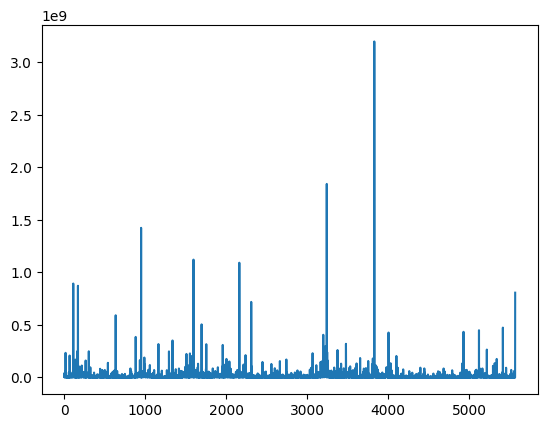

In [11]:
#visualizando os dados
plt.plot(df_bpc_fpm['bpc_val']);

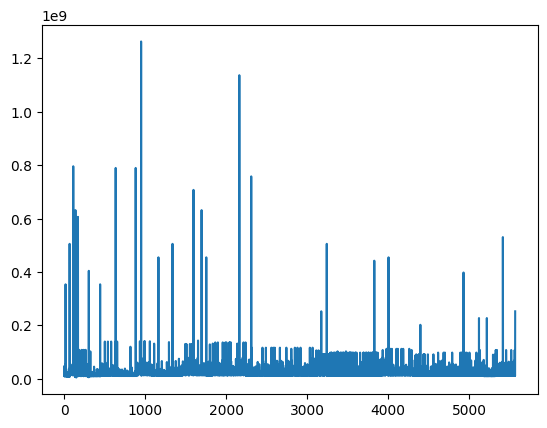

In [12]:
plt.plot(df_bpc_fpm['repasse_fpm']);

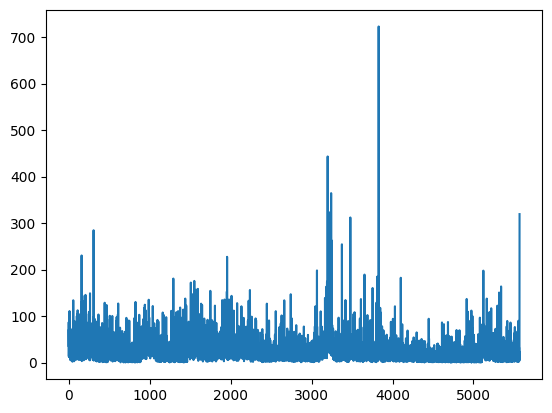

In [13]:
plt.plot(df_bpc_fpm['fpm_bpc']);

<Axes: >

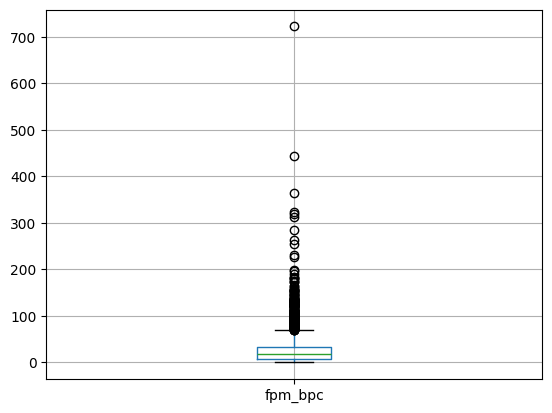

In [14]:
df_bpc_fpm[['fpm_bpc']].boxplot()

In [15]:
indice_max = df_bpc_fpm['fpm_bpc'].idxmax()
linha_max = df_bpc_fpm.loc[indice_max]
linha_max

ibge_6                   355030
ano                        2022
bpc_ben                 2633985
bpc_pcd_ben            971999.0
bpc_idoso_ben         1661986.0
bpc_pcd_val       1179028227.29
bpc_idoso_val     2016366837.97
bpc_val           3195395065.26
Município_UF     São Paulo - SP
repasse_fpm        442083084.93
fpm_bpc              722.804191
Name: 3829, dtype: object

In [16]:
maiores_valores = df_bpc_fpm['fpm_bpc'].nlargest(10)
menores_valores = df_bpc_fpm['fpm_bpc'].nsmallest(10)

In [17]:
maiores_valores

3829    722.804191
3199    443.197840
3242    364.299404
3224    322.933582
5569    319.213344
3479    311.965582
308     284.499485
3247    262.812670
3375    254.246636
160     230.249065
Name: fpm_bpc, dtype: float64

In [18]:
menores_valores

4394    0.069398
5088    0.126837
702     0.151358
4716    0.158546
4724    0.158546
5077    0.179686
4976    0.232534
1248    0.232659
680     0.244508
5034    0.306526
Name: fpm_bpc, dtype: float64

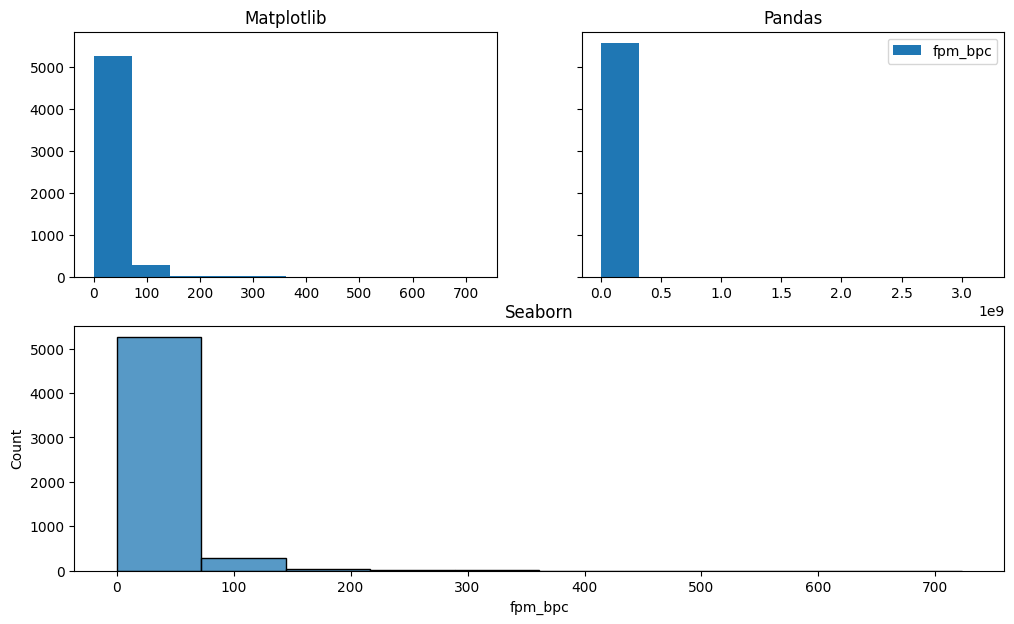

In [19]:
fig = plt.figure(figsize=(12,7))

ax1 = plt.subplot(2, 2, 1)
ax1.set_title('Matplotlib')
ax1.hist(x=df_bpc_fpm['fpm_bpc'], bins=10);

ax2 = plt.subplot(2, 2, 2, sharey=ax1)
ax2.set_title('Pandas')
df_bpc_fpm.plot.hist(column='fpm_bpc', bins=10, ax=ax2);

ax3 = plt.subplot(2, 1, 2)
plt.title('Seaborn')

sns.histplot(data=df_bpc_fpm, x='fpm_bpc', 
             multiple='stack', bins=10, ax=ax3);
             
# sns.histplot(data=pd_pbf_cadUnico, x='pbf_cadUnico_pob_ep', hue='Data', 
#             multiple='stack', bins=10, ax=ax3);

In [20]:
#removendo outliers
retira_maiores_outliers = df_bpc_fpm['fpm_bpc'] < 100
df_sem_maiores_outliers = df_bpc_fpm[retira_maiores_outliers] 


df_sem_maiores_outliers.describe()

,ibge_6,ano,bpc_ben,bpc_pcd_ben,bpc_idoso_ben,bpc_pcd_val,bpc_idoso_val,bpc_val,repasse_fpm,fpm_bpc
count,5442.000000,5442.0,5442.000000,5442.000000,5442.000000,5.442000e+03,5.442000e+03,5.442000e+03,5.442000e+03,5442.000000
mean,326144.653620,2022.0,7043.433113,4152.483278,2890.949835,5.035849e+06,3.507227e+06,8.543076e+06,2.421729e+07,22.741984
std,98481.947062,0.0,22865.673305,11954.111536,11312.935171,1.449736e+07,1.372379e+07,2.773436e+07,3.628848e+07,19.787423
min,110001.000000,2022.0,6.000000,3.000000,0.000000,3.636600e+03,0.000000e+00,7.272600e+03,4.817499e+06,0.069398
25%,251270.500000,2022.0,807.000000,550.000000,214.000000,6.666018e+05,2.593693e+05,9.780888e+05,1.198303e+07,7.878325
50%,314765.000000,2022.0,2281.000000,1472.000000,692.000000,1.785294e+06,8.399228e+05,2.767057e+06,1.602671e+07,16.960852
75%,412057.500000,2022.0,6643.750000,4157.750000,2282.500000,5.041639e+06,2.767659e+06,8.055972e+06,2.625685e+07,31.476630
max,522230.000000,2022.0,899658.000000,430018.000000,469640.000000,5.215209e+08,5.697033e+08,1.091224e+09,1.136785e+09,99.970351


In [21]:
df_sem_maiores_outliers.shape

(5442, 11)

<Axes: >

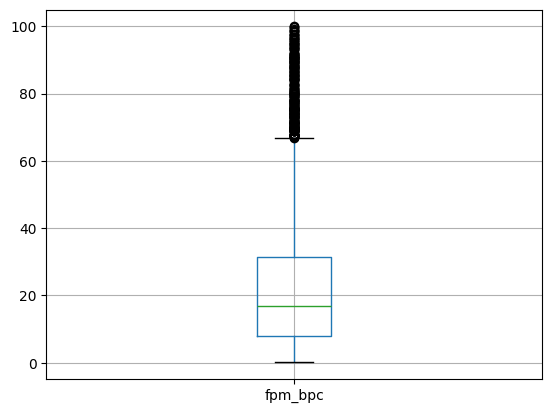

In [22]:
df_sem_maiores_outliers[['fpm_bpc']].boxplot()

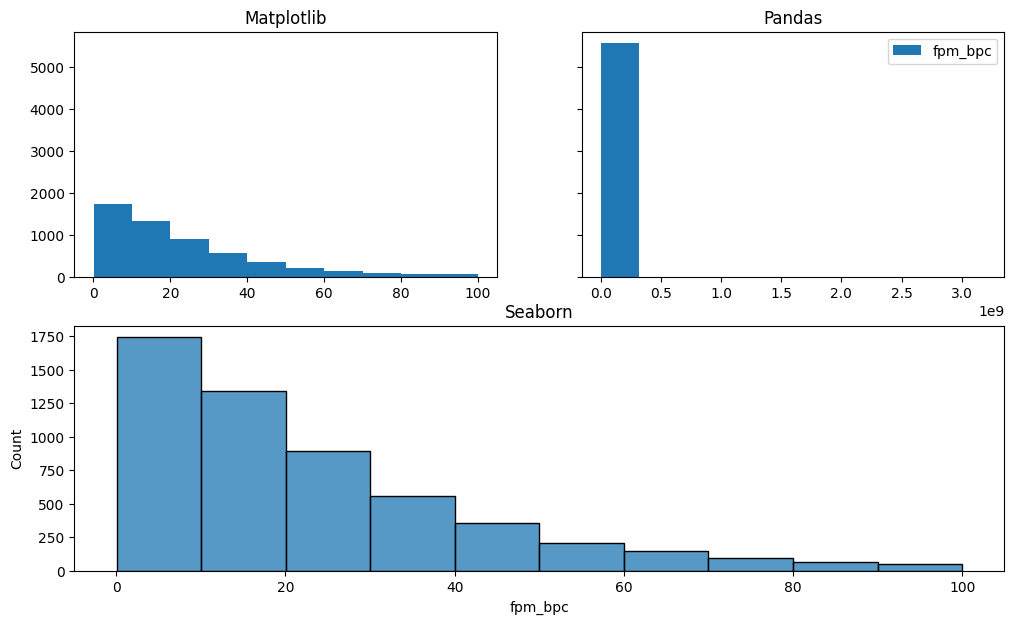

In [23]:
fig = plt.figure(figsize=(12,7))

ax1 = plt.subplot(2, 2, 1)
ax1.set_title('Matplotlib')
ax1.hist(x=df_sem_maiores_outliers['fpm_bpc'], bins=10);

ax2 = plt.subplot(2, 2, 2, sharey=ax1)
ax2.set_title('Pandas')
df_bpc_fpm.plot.hist(column='fpm_bpc', bins=10, ax=ax2);

ax3 = plt.subplot(2, 1, 2)
plt.title('Seaborn')

sns.histplot(data=df_sem_maiores_outliers, x='fpm_bpc', 
             multiple='stack', bins=10, ax=ax3);
             
# sns.histplot(data=pd_pbf_cadUnico, x='pbf_cadUnico_pob_ep', hue='Data', 
#             multiple='stack', bins=10, ax=ax3);

In [24]:
df_bpc_fpm

,ibge_6,ano,bpc_ben,bpc_pcd_ben,bpc_idoso_ben,bpc_pcd_val,bpc_idoso_val,bpc_val,Município_UF,repasse_fpm,fpm_bpc
0,110001,2022,6201,5040.0,1161.0,6.112212e+06,1.409569e+06,7.521781e+06,Alta Floresta D'Oeste - RO,2.097031e+07,35.868723
1,110002,2022,34260,21807.0,12453.0,2.645554e+07,1.510903e+07,4.156456e+07,Ariquemes - RO,4.793213e+07,86.715461
2,110003,2022,967,771.0,196.0,9.356818e+05,2.375551e+05,1.173237e+06,Cabixi - RO,8.987274e+06,13.054425
3,110004,2022,24588,16599.0,7989.0,2.012921e+07,9.687653e+06,2.981687e+07,Cacoal - RO,4.194061e+07,71.093064
4,110005,2022,5171,4090.0,1081.0,4.958360e+06,1.311391e+06,6.269752e+06,Cerejeiras - RO,1.797455e+07,34.881277
...,...,...,...,...,...,...,...,...,...,...,...
5565,522200,2022,3732,2194.0,1538.0,2.661577e+06,1.866495e+06,4.528072e+06,Vianópolis - GO,1.883207e+07,24.044471
5566,522205,2022,1762,1209.0,553.0,1.465338e+06,6.702474e+05,2.135586e+06,Vicentinópolis - GO,1.129924e+07,18.900255
5567,522220,2022,1671,1259.0,412.0,1.527127e+06,5.005573e+05,2.027684e+06,Vila Boa - GO,1.129924e+07,17.945309
5568,522230,2022,386,342.0,44.0,4.145098e+05,5.332867e+04,4.678385e+05,Vila Propício - GO,1.129924e+07,4.140441


In [25]:
#discretizando ou criando classes
df_bpc_fpm['indice_bpc'] = pd.cut(df_bpc_fpm['fpm_bpc'], bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 800]) 


In [26]:
indice_bpc_12c = df_bpc_fpm['indice_bpc'].value_counts()
indice_bpc_12c = pd.DataFrame(indice_bpc_12c)
df_indice_bpc_12c = indice_bpc_12c.reset_index(drop=False).copy()
df_indice_bpc_12c

,indice_bpc,count
0,"(0, 10]",1724
1,"(10, 20]",1346
2,"(20, 30]",898
3,"(30, 40]",559
4,"(40, 50]",355
5,"(50, 60]",209
6,"(60, 70]",143
7,"(100, 800]",127
8,"(70, 80]",95
9,"(80, 90]",62


In [48]:
df_indice_bpc_12c['Classe'] = [1,2,3,4,5,6,7,11,8,9,10]
df_indice_bpc_12c

,indice_bpc,count,Classe
0,"(0, 10]",1724,1
1,"(10, 20]",1346,2
2,"(20, 30]",898,3
3,"(30, 40]",559,4
4,"(40, 50]",355,5
5,"(50, 60]",209,6
6,"(60, 70]",143,7
7,"(100, 800]",127,11
8,"(70, 80]",95,8
9,"(80, 90]",62,9


C:\Users\mauri\AppData\Local\Temp\ipykernel_22180\3588993104.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



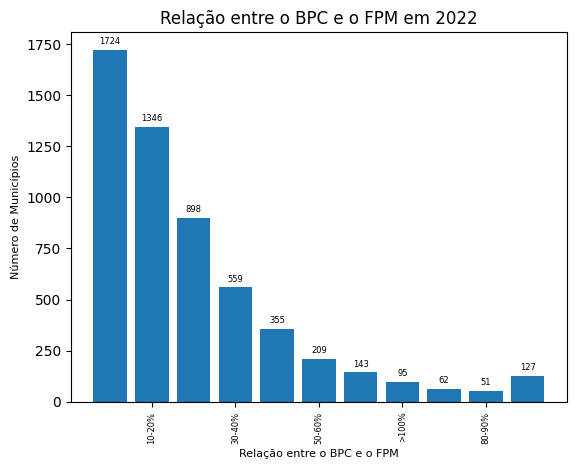

In [54]:
fig10c, ax = plt.subplots()

X = df_indice_bpc_12c['Classe']
Y = df_indice_bpc_12c['count']
bars = ax.bar(X, Y)

plt.title('Relação entre o BPC e o FPM em 2022')

ax.set_xlabel('Relação entre o BPC e o FPM', fontsize=8)
ax.set_ylabel('Número de Municípios', fontsize=8)

ax.set_xticklabels(['','10-20%', '30-40%', '50-60%', '>100%', '80-90%'], 
                   rotation=90, fontsize=6)

# Adicione etiquetas em todas as barras
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Deslocamento vertical das etiquetas
                textcoords="offset points",
                ha='center', va='bottom', fontsize=6)

plt.xticks(rotation=90, fontsize=6)

plt.show()
